In [1]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_datasets as tfds

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from tensorflow import keras
from keras import layers
# from sklearn import preprocessing
# Make numpy values easier to read.
# np.set_printoptions(precision=3, suppress=True)

# physical_devices = tf.config.list_physical_devices("gpu")
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.set_floatx('float64')
tf.compat.v1.enable_eager_execution()


# np.random.seed(101)
# tf.random.set_seed(101)

2023-02-05 20:08:27.947959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GPUs Available:  0


2023-02-05 20:08:29.115685: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-02-05 20:08:29.115707: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vn
2023-02-05 20:08:29.115713: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vn
2023-02-05 20:08:29.115818: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-02-05 20:08:29.115832: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.108.3
2023-02-05 20:08:29.115837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.108.3


In [2]:
# preprocessing of data

leakage_train_100 = pd.read_csv("leakage_dataset_train_100.csv")
leakage_train_1000 = pd.read_csv("leakage_dataset_train_1000.csv")
leakage_val_1000 = pd.read_csv("leakage_dataset_validation_1000.csv")

train_ds = leakage_train_100
val_ds = leakage_val_1000

train_ds = train_ds.sample(frac=1)
val_ds = val_ds.sample(frac=1)
 
batch_size = 25
epochs = 5
# train_ds = train_ds.repeat()
# train_ds = train_ds.shuffle(buffer_size=1024, seed=0)
# train_ds = train_ds.batch(batch_size=batch_size)
# train_ds = train_ds.prefetch(buffer_size=1)

# val_ds = val_ds.batch(batch_size=batch_size)
# val_ds = val_ds.prefetch(buffer_size=1)


# leakage_train_100.head()
# leakage_val_1000.head()

# #create two output arrays
# def format_output(data):
#     data = data.copy()
#     y1 = data.pop('y1')
#     y1 = np.array(y1)
#     y2 = data.pop('y2')
#     y2 = np.array(y2)
#     return y1, y2

X_train = train_ds.iloc[:,2:].to_numpy()
Y_train = train_ds.iloc[:,:2]

#splitting of x and y variable
# X_train = leakage_train_1000.iloc[:,2:].to_numpy()
# Y_train = leakage_train_1000.iloc[:,:2]

num_rows, num_cols = X_train.shape

X_validation = val_ds.iloc[:,2:].to_numpy()
Y_validation = val_ds.iloc[:,:2]

scX = preprocessing.StandardScaler()
stY = preprocessing.StandardScaler()

# def data_scaling(X_train, X_validation, Y_train, Y_validation, scX, stY):
#     X_train = scX.fit_transform(X_train)
#     X_validation = scX.transform(X_validation)

#     Y_train = stY.fit_transform(Y_train)
#     Y_validation = stY.transform(Y_validation)

#     return X_train, X_validation, Y_train, Y_validation

# X_train, X_validation, Y_train, Y_validation = data_scaling(X_train, X_validation, Y_train, Y_validation, scX, stY)
# Y_train = pd.DataFrame(Y_train, columns = ['y1','y2'])
# Y_validation = pd.DataFrame(Y_validation, columns = ['y1','y2'])

# y1_train, y2_train = format_output(Y_train)
# y1_validation, y2_validation = format_output(Y_validation)

Y_train = Y_train.to_numpy()
Y_validation = Y_validation.to_numpy()

In [3]:
# NN architechture - keras Functional API
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(4, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

# dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, name = 'y2')
dense2_1 = tf.keras.layers.Dense(2)

x=dense1(inputs)

outputs1=dense2_1(x)
# outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs1, name = 'leakge_functional_model')

print(model.summary())

starter_learning_rate = 1e-4
end_learning_rate = 1e-8
decay_steps = 10000
scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate= starter_learning_rate,
    decay_steps= decay_steps,
    end_learning_rate= end_learning_rate,
    power=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
              loss=tf.keras.losses.mean_squared_error,
              metrics = [tf.keras.metrics.MeanSquaredError()]
)

history = model.fit(X_train, Y_train, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation, Y_validation),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

predictions = model.predict(X_validation)

# even for a primilinary result, the loss is pretty good

2023-02-05 20:08:29.279951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "leakge_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
4/4 - 0s - loss: 0.3651 - mean_squared_error: 0.3651 - val_loss: 0.3530 - val_mean_squared_error: 0.3530 - 317ms/epoch - 79ms/step
Epoch 2/5
4/4 - 0s - loss: 0.3650 - mean_squared_error: 0.3650 - val_loss: 0.3529 - val_mean_squared_error: 0.3529 - 36ms/epoch - 9ms/step
Epoch 3/5
4/4 - 0s - loss:

In [4]:
def learning_curves(history)   :
    sns.set_style('darkgrid', {'axes.facecolor': '.9'})
    sns.set_context('notebook')

    # your code
    ### Learning curves
    history_frame = pd.DataFrame(history.history)
    history_frame.plot(figsize=(8, 5))
    plt.show()

rmse of y1:  0.607209360993561
rmse of y2:  0.579861534485009


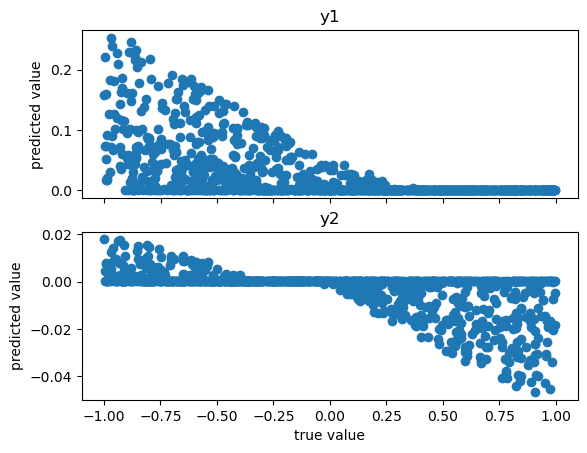

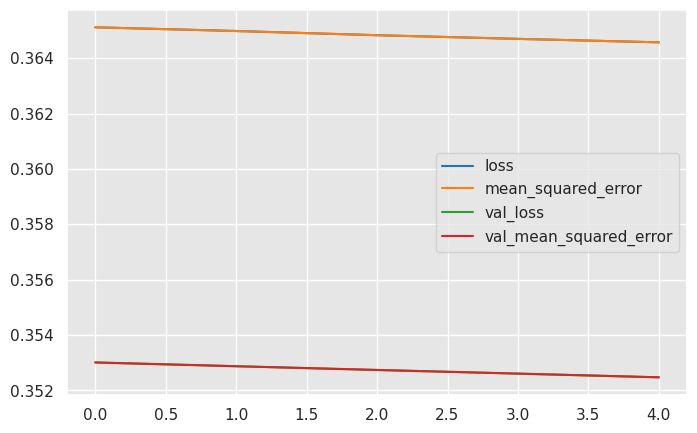

In [5]:
def prediction_accuracy(predictions, Y_validation): 
    predictions = predictions.transpose()
    Y_validation = Y_validation.transpose()
    y1 = predictions[0]
    y2 = predictions[1]
    y1_validation = Y_validation[0]
    y2_validation = Y_validation[1]
    fig, axs = plt.subplots(2)
    # print(y1_validation.shape, y1.shape)
    # print(y2_validation.shape, y2.shape)
    # fig.suptitle('')
    axs[0].scatter(y1_validation, y1)
    axs[0].set_title('y1')
    axs[1].scatter(y2_validation, y2)
    axs[1].set_title('y2')
    for ax in axs.flat:
        ax.set(xlabel='true value', ylabel='predicted value')
    for ax in axs.flat:
        ax.label_outer()

    print("rmse of y1: ", mean_squared_error(y1_validation, y1, squared=False))
    print("rmse of y2: ", mean_squared_error(y2_validation, y2, squared=False))

prediction_accuracy(predictions, Y_validation)
learning_curves(history)

In [6]:
# data Augmentation
# Requires cleaning up

def rotation_matrix(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def Augmentation_clock(x,y):

    x = x.copy()
    y = y.copy()
    # print(y)
    y_aug = np.transpose(np.matmul(rotation_matrix(-90), np.transpose(y)))
    # print(y_aug)

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    # print(x0.shape)

    x[:,0] = x3
    x[:,1] = x0
    x[:,2] = x1
    x[:,3] = x2
 
    return x,y_aug


def Augmentation_flip(x,y):
    x = x.copy()
    y = y.copy()
    x = np.flip(x, axis=1)
    y[:,1] = -1 * y[:,1]
    return x,y

def Augmentation_anticlock(x,y):

    x = x.copy()
    y = y.copy()
    y_aug = np.transpose(np.matmul(rotation_matrix(90), np.transpose(y)))

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x0
 
    return x,y_aug

# # test inputs
# X_train = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# # print(X_train)
# Y_train = np.array([[15,16], [17,18], [19,20]])
# num_rows, num_cols = X_train.shape

def data_augmentation(x,y):
    x_aug1,y_aug1 = Augmentation_clock(x, y)
    x_aug2,y_aug2 = Augmentation_clock(x_aug1,y_aug1)
    x_aug3,y_aug3 = Augmentation_clock(x_aug2,y_aug2)
    x_aug4,y_aug4 = Augmentation_flip(x_aug3,y_aug3)
    x_aug5,y_aug5 = Augmentation_clock(x_aug4,y_aug4)
    x_aug6,y_aug6 = Augmentation_clock(x_aug5,y_aug5)
    x_aug7,y_aug7 = Augmentation_clock(x_aug6,y_aug6)
    X_train_Aug = np.concatenate((x, x_aug1, x_aug2, x_aug3, x_aug4, x_aug5, x_aug6, x_aug7))
    Y_train_Aug = np.concatenate((y, y_aug1, y_aug2, y_aug3, y_aug4, y_aug5, y_aug6, y_aug7))

    return X_train_Aug, Y_train_Aug

X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)
X_validation_Aug, Y_validation_Aug = data_augmentation(X_validation, Y_validation)

Model: "leakge_aug_functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
32/32 - 0s - loss: 0.3671 - mean_squared_error: 0.3671 - val_loss: 0.3514 - val_mean_squared_error: 0.3514 - 408ms/epoch - 13ms/step
Epoch 2/5
32/32 - 0s - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3476 - val_mean_squared_error: 0.3476 - 178ms/epoch - 6ms/step
Epoch 3/5
32/32 -

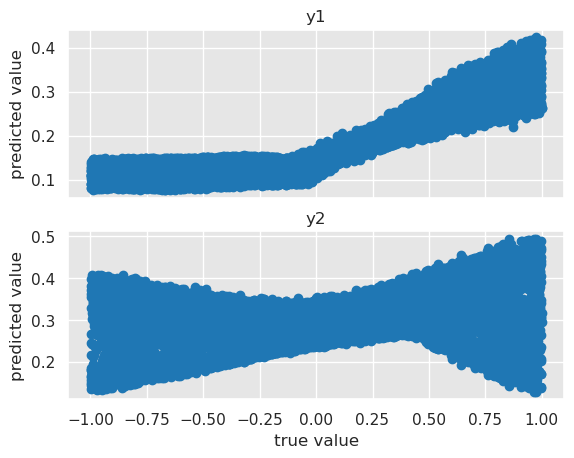

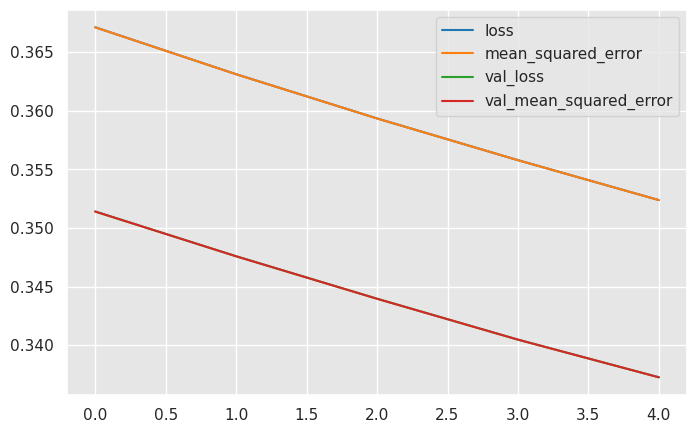

In [7]:
# tf.random.set_seed(42) 

# Model trained on Augmented dataset
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(4, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

# dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, name = 'y2')
dense2_1 = tf.keras.layers.Dense(2)

x=dense1(inputs)

outputs1=dense2_1(x)
# outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs1, name = 'leakge_aug_functional_model')

print(model.summary())

starter_learning_rate = 1e-4
end_learning_rate = 1e-8
decay_steps = 10000
scheduler = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate= starter_learning_rate,
    decay_steps= decay_steps,
    end_learning_rate= end_learning_rate,
    power=1)

history = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler),
              loss=tf.keras.losses.mean_squared_error,
              metrics = [tf.keras.metrics.MeanSquaredError()]
)

# y_aug = {
#     "y1" : Y_train_Aug[:,0],
#     "y2" : Y_train_Aug[:,1]
# }

# y_aug_valid = {
#     "y1" : Y_validation_Aug[:,0],
#     "y2" : Y_validation_Aug[:,1]
# }

history = model.fit(X_train_Aug, y=Y_train_Aug, epochs=epochs, batch_size= batch_size, verbose=2, validation_data=(X_validation_Aug, Y_validation_Aug),
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

predictions = model.predict(X_validation_Aug)

# even for a primilinary result, the loss is pretty good

prediction_accuracy(predictions, Y_validation_Aug)
learning_curves(history)